In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
train_batch_size = 100
test_batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class CNN_Model(nn.Module):
    def __init__(self, num_channels, fc_size):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels * 2)
        self.conv3 = nn.Conv2d(num_channels * 2, num_channels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_channels * 4)
        
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self._forward_features(dummy_input)
        num_features = dummy_output.view(dummy_output.size(0), -1).size(1)
        
        self.fc1 = nn.Linear(num_features, fc_size)
        self.fc2 = nn.Linear(fc_size, 10)

    def _forward_features(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
def train_single_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0

    for inputs, labels in train_loader:
        # Move the inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted_train == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / total_samples_train
    return avg_train_loss, train_accuracy

In [7]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_test_loss = 0.0
    total_correct_test = 0
    total_samples_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the inputs and labels to the GPU (or CPU based on availability)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            total_test_loss += criterion(outputs, labels).item()

            _, predicted_test = torch.max(outputs.data, 1)
            total_samples_test += labels.size(0)
            total_correct_test += (predicted_test == labels).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_correct_test / total_samples_test
    return avg_test_loss, test_accuracy

In [8]:
def log_epoch_results(epoch, model, avg_train_loss, avg_test_loss, train_accuracy, test_accuracy):
    print(f'Model: Channels={model.conv1.out_channels}, FC Size={model.fc1.out_features}, '
          f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [9]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        avg_train_loss, train_accuracy = train_single_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        avg_test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        log_epoch_results(epoch, model, avg_train_loss, avg_test_loss, train_accuracy, test_accuracy)

    return train_losses, test_losses, train_accuracies, test_accuracies


In [10]:
def create_models(num_models=10):
    models = []
    for i in range(1, num_models + 1):
        num_channels = 16 * i
        fc_size = 120 * i
        model = CNN_Model(num_channels, fc_size).to(device)
        models.append(model)
    return models

In [11]:
def train_models(models, trainloader, testloader):
    results = []
    for i, model in enumerate(models, 1):
        print(f"Training Model {i}:")
        loss_func = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate_model(model, trainloader, testloader, optimizer, loss_func)
        results.append((model.conv1.out_channels, model.fc1.out_features, train_losses, test_losses, train_accuracies, test_accuracies))
    return results

In [12]:
def calculate_num_parameters(conv_channels, fc_size):
    return conv_channels * conv_channels * 3 * 3 + fc_size * conv_channels * 3 * 3 + fc_size + fc_size * 10

In [13]:
def extract_results(results):
    num_parameters = []
    train_losses_list = []
    test_losses_list = []
    train_accuracies_list = []
    test_accuracies_list = []

    for result in results:
        conv_channels, fc_size = result[0], result[1]
        num_params = calculate_num_parameters(conv_channels, fc_size)
        num_parameters.append(num_params)
        train_losses_list.append(result[2])
        test_losses_list.append(result[3])
        train_accuracies_list.append(result[4])
        test_accuracies_list.append(result[5])

    return num_parameters, train_losses_list, test_losses_list, train_accuracies_list, test_accuracies_list

In [14]:
models = create_models(num_models=10)
results = train_models(models, trainloader, testloader)
num_parameters, train_losses_list, test_losses_list, train_accuracies_list, test_accuracies_list = extract_results(results)

Training Model 1:
Model: Channels=16, FC Size=120, Epoch 1, Train Loss: 1.1517, Test Loss: 0.9565, Train Accuracy: 0.5854, Test Accuracy: 0.6623
Model: Channels=16, FC Size=120, Epoch 2, Train Loss: 0.7968, Test Loss: 0.8403, Train Accuracy: 0.7154, Test Accuracy: 0.7021
Model: Channels=16, FC Size=120, Epoch 3, Train Loss: 0.6486, Test Loss: 0.7824, Train Accuracy: 0.7719, Test Accuracy: 0.7271
Model: Channels=16, FC Size=120, Epoch 4, Train Loss: 0.5428, Test Loss: 0.7728, Train Accuracy: 0.8086, Test Accuracy: 0.7399
Model: Channels=16, FC Size=120, Epoch 5, Train Loss: 0.4523, Test Loss: 0.8030, Train Accuracy: 0.8418, Test Accuracy: 0.7374
Model: Channels=16, FC Size=120, Epoch 6, Train Loss: 0.3742, Test Loss: 0.8403, Train Accuracy: 0.8698, Test Accuracy: 0.7423
Model: Channels=16, FC Size=120, Epoch 7, Train Loss: 0.3043, Test Loss: 0.9137, Train Accuracy: 0.8943, Test Accuracy: 0.7364
Model: Channels=16, FC Size=120, Epoch 8, Train Loss: 0.2508, Test Loss: 0.9666, Train Accura

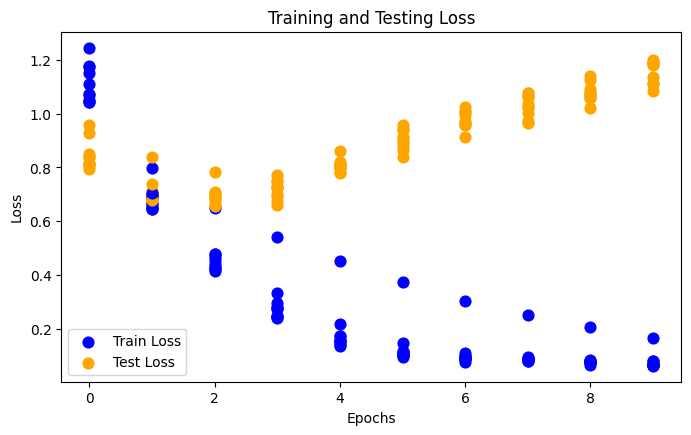

In [17]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
for i in range(len(num_parameters)):
    plt.scatter(range(len(train_losses_list[i])), train_losses_list[i], label=f'{num_parameters[i]} parameters', color='blue', s=60)
    plt.scatter(range(len(test_losses_list[i])), test_losses_list[i], color='orange', s=60)

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])

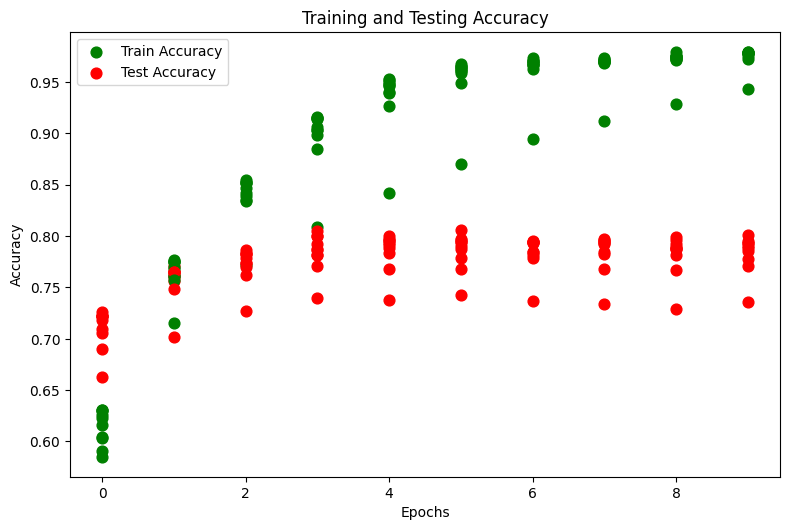

In [19]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 2)
for i in range(len(num_parameters)):
    plt.scatter(range(len(train_accuracies_list[i])), train_accuracies_list[i], label=f'{num_parameters[i]} parameters', color='green', s=60)
    plt.scatter(range(len(test_accuracies_list[i])), test_accuracies_list[i], color='red', s=60)
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.tight_layout()
plt.show()